# Evaluating pupil detection algorithms

## Prepare the analysis

In [1]:
# %pip install pandas numpy imageio seaborn matplotlib scipy ipympl scikit-learn

In [2]:
from pathlib import Path
import math
from typing import Tuple, Sequence
import json

import pandas as pd
import imageio.v3 as iio
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist, euclidean

class Image:
    def __init__(self, name: str):
        file = next(Path("/data/facets/data").rglob(f"*{name}"))
        self.image = iio.imread(str(file))

    def plot_to(self, ax):
        ax.imshow(self.image, cmap="gray")
        ax.axis("off")

    def plot_distance_contour_to(self, ax, center: Tuple[float, float], color_map, threshold: float = 1.0, levels: Sequence[float] = None, plot_legend: bool = False):
        if isinstance(levels, int):
            levels = np.linspace(0, threshold, levels, endpoint=True)
        
        x = np.arange(0.0, self.image.shape[0], 1)
        y = np.arange(0.0, self.image.shape[1], 1)
        xv, yv = np.meshgrid(x, y)

        distances = np.sqrt((xv - center[0]) ** 2 + (yv - center[1]) ** 2)
        contour = ax.contourf(xv, yv, distances, vmin=0, vmax=threshold, levels=levels, alpha=0.3, cmap=color_map);
        if plot_legend:
            ax.figure.colorbar(contour, ax=ax)


## Step 1: Load the ground-truth data (or draw samples for the annotation)

In [6]:
OUTPUT_PATH = Path("/data/facets/data_annotated")

In [ ]:
"""
import shutil
import random

PATTERNS = ["*left_max.png", "*right_max.png"]
if not OUTPUT_PATH.is_dir():
    rng = random.Random(42)
    OUTPUT_PATH.mkdir(parents=True, exist_ok=False)
    for path in Path("/data/facets/data").glob("*"):
        if not path.is_dir():
            continue
        for pattern in PATTERNS:
            image_paths = list(path.glob(pattern))
            if len(image_paths) == 0:
                continue
            image_path: Path = rng.choice(image_paths)
            print(image_path)
            shutil.copy(image_path, OUTPUT_PATH / image_path.name)
"""

# Commenting in the previous code allows random sampling from images

In [7]:
annotated_data = []
for annotation in (OUTPUT_PATH / "annotations").glob("*.json"):
    with annotation.open("r") as annotation_data:
        annotation_data = json.load(annotation_data)
    
        # Parste the center
        center = annotation_data["shapes"][0]
        is_well_defined = center["label"] == "PupilCenter"
        center = center["points"][0]

        annotated_data.append((annotation.stem + ".png", center[0], center[1], is_well_defined))

annotated_data.extend([
    ("0bdc64d3-6f7b-419f-b51f-7ec6a0089b92_17209_left.png", 70, 22, True),
    ("1cfbe940-9389-40f6-9225-cad2cff35451_17629_left.png", 71, 55, True),
    ("1e30405a-a4c8-4692-95ca-00cf2212218f_17196_left.png", 58, 42, True),
    ("2b250d43-e45f-4d92-a647-ad0d25a73736_17088_right.png", 85, 97, True),
    ("2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_17678_right.png", 127, 73, True),
    ("2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_18667_right.png", 177, 74, False), # Hard
])

annotated_data = pd.DataFrame.from_records(annotated_data, index="File", columns=["File", "X", "Y", "WellDefined"])
assert annotated_data.index.is_unique, "Files not unique"

annotated_data

,X,Y,WellDefined
File,,,
0637fc4a-23c5-48b5-9e98-5c174fbbc615_17908_right.png,109.121272,64.190855,True
0637fc4a-23c5-48b5-9e98-5c174fbbc615_18186_left.png,61.606362,59.220676,True
0637fc4a-23c5-48b5-9e98-5c174fbbc615_49271_right_max.png,108.524851,69.359841,True
0637fc4a-23c5-48b5-9e98-5c174fbbc615_49359_left_max.png,68.166998,53.455268,True
08fde77b-d597-49a7-8a7c-f3a18ea4409a_18566_right.png,112.898608,87.053678,True
...,...,...,...
1cfbe940-9389-40f6-9225-cad2cff35451_17629_left.png,71.000000,55.000000,True
1e30405a-a4c8-4692-95ca-00cf2212218f_17196_left.png,58.000000,42.000000,True
2b250d43-e45f-4d92-a647-ad0d25a73736_17088_right.png,85.000000,97.000000,True


## Step 2: Visualize our definition of "error"

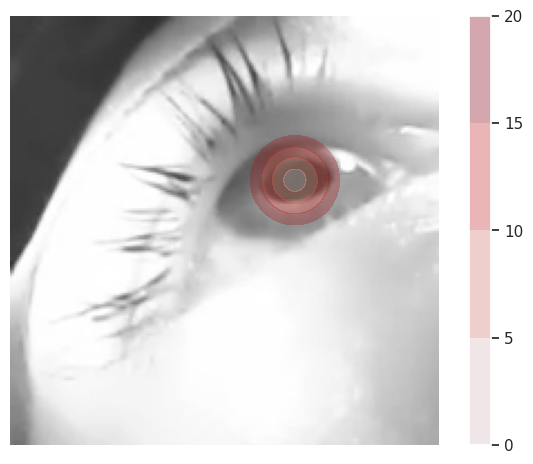

In [8]:
FILE = "2f9d4e6c-75e6-43bc-bdd7-6dde9d73800d_17678_right.png"
ERROR_TRHESHOLD = [0, 5, 10, 15, 20]
COLOR_MAP = mpl.colormaps['Reds']

img = Image(FILE)
center = annotated_data.loc[FILE][["X", "Y"]].to_numpy()

fig, ax = plt.subplots(1, 1)
img.plot_to(ax)
img.plot_distance_contour_to(ax, center=center, threshold=20, levels=[0, 5, 10, 15, 20], color_map=COLOR_MAP, plot_legend=True)

fig.tight_layout()
fig.savefig("error_impact.png", dpi=500)

## Step 3: Evaluate the pupil detection algorithms

### Load the predictions by the different pupil detectors

In [ ]:
results = pd.read_csv("/data/facets/data/result.tsv", sep="\t").set_index("File")
results["Detector"] = results["Detector"].replace({
    "bore:0.1": "Fuhl et al. (2018)",
    "cprd:0.1": "Wan et al. (2021)",
    "edgeguided:0.1": "Wang et al. (2021)",
    "ellseg:0.1": "Kothari et al. (2021)",
    "else:0.1": "Fuhl et al. (2016)",
    "excuse:0.1": "Fuhl et al. (2015)",
    "pupilellipsefiterror:0.1": "Akinlar, Kucukkartal, and Topal (2022)",
    "pupillabs:0.1": "Kassner, Patera, and Bulling (2014)",
    "pupillocator:0.1": "Eivazi et al. (2019)",
    "pure:0.1": "Santini, Fuhl, and Kasneci (2018)",
    "starburst:0.1": "Li, Winfield, and Parkhurst (2005)",
    "swirski:0.1": "Swirski, Bulling, and Dodgson (2012)",
    "timms:0.1": "Krause, and Essig (2019)"
})

### Calculate the error

In [ ]:
annotated_files_with_errors = []
pupil_detectors = list(results["Detector"].unique())

for annotated_sample in annotated_data.itertuples():
    subset = results.loc[annotated_sample.Index]
    annotated_center = [annotated_sample.X, annotated_sample.Y]

    # Calculate the pupil detectors
    pupil_detectors_error = [
        euclidean(
            annotated_center, 
            subset[subset["Detector"] == detector][["X", "Y"]].to_numpy().flatten()
        )
        for detector in pupil_detectors
    ]

pupil_detector_errors = pd.melt(
    annotated_files_with_errors, 
    value_vars=pupil_detectors, 
    id_vars=["File"], 
    var_name="Detector", 
    value_name="Pixel error"
)

pupil_detector_errors

## Step 4: Compare the plots visually

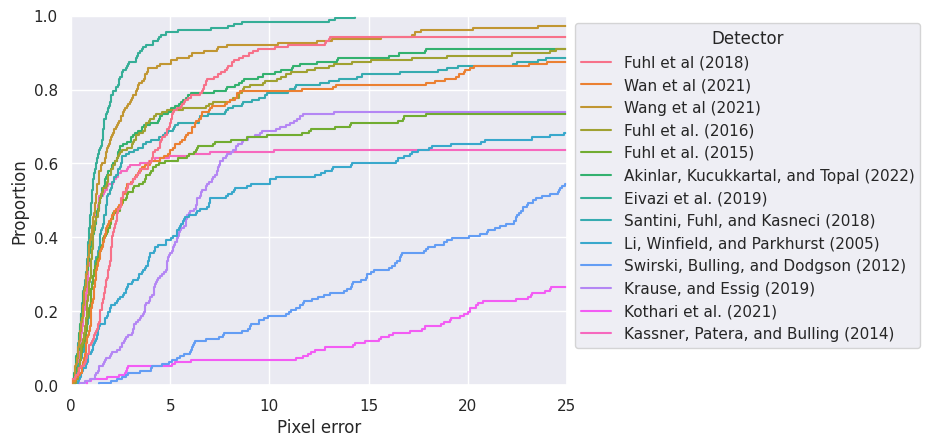

In [11]:
ax = sns.ecdfplot(
    data=pupil_detector_errors, 
    x="Pixel error", 
    hue="Detector", 
    palette=sns.color_palette("husl", len(pupil_detectors))
)
ax.set_xlim(0, 25)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('error_ecdf.png', bbox_inches='tight', dpi=500)

## Step 5: Test for statistical differences

In [12]:
ks_2samp(
    pupil_detector_errors[pupil_detector_errors["Detector"] == "Eivazi et al. (2019)"]["Pixel error"].to_numpy(),
    pupil_detector_errors[pupil_detector_errors["Detector"] == "Kassner, Patera, and Bulling (2014)"]["Pixel error"].to_numpy(),
    alternative="greater"
)

KstestResult(statistic=0.36363636363636365, pvalue=4.87615933248942e-11, statistic_location=14.290826242737197, statistic_sign=1)